In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.config import list_physical_devices
import pickle
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
list_physical_devices() # Check for GPU (however the notebook will work without one)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
df = pd.read_csv('/kaggle/input/battery-remaining-useful-life-rul/Battery_RUL.csv')
df.drop(columns='Cycle_Index', inplace=True) # Cycle index is not a feature and it can lead to a data leak

In [4]:
df.head(10)

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112
1,7408.64,1172.512500,4.246,3.220,5508.992000,6762.02,10500.35,1111
2,7393.76,1112.992000,4.249,3.224,5508.993000,6762.02,10420.38,1110
3,7385.50,1080.320667,4.250,3.225,5502.016000,6762.02,10322.81,1109
4,65022.75,29813.487000,4.290,3.398,5480.992000,53213.54,56699.65,1107
5,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106
6,5955.30,1220.135329,4.013,3.501,5017.495000,5967.55,5967.55,1105
7,5951.20,1220.135329,4.014,3.501,5017.496000,5962.21,5962.21,1104
8,5945.44,1216.920914,4.014,3.501,5009.993667,5954.91,5954.91,1103
9,435251.49,263086.078000,4.267,3.086,269.984000,443700.02,443700.02,1102


In [5]:
df.shape

(15064, 8)

For convenience, renaming the columns as per the dataset creator's notation:

In [6]:
new_col_labels = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'RUL']

df_column_dict = dict(zip(df.columns, new_col_labels))
df_column_dict

{'Discharge Time (s)': 'F1',
 'Decrement 3.6-3.4V (s)': 'F2',
 'Max. Voltage Dischar. (V)': 'F3',
 'Min. Voltage Charg. (V)': 'F4',
 'Time at 4.15V (s)': 'F5',
 'Time constant current (s)': 'F6',
 'Charging time (s)': 'F7',
 'RUL': 'RUL'}

In [7]:
df.rename(mapper=df_column_dict, axis=1, inplace=True)

## Exploratory Analysis and Preprocessing

In [8]:
# No NAs:

df.isnull().sum()

F1     0
F2     0
F3     0
F4     0
F5     0
F6     0
F7     0
RUL    0
dtype: int64

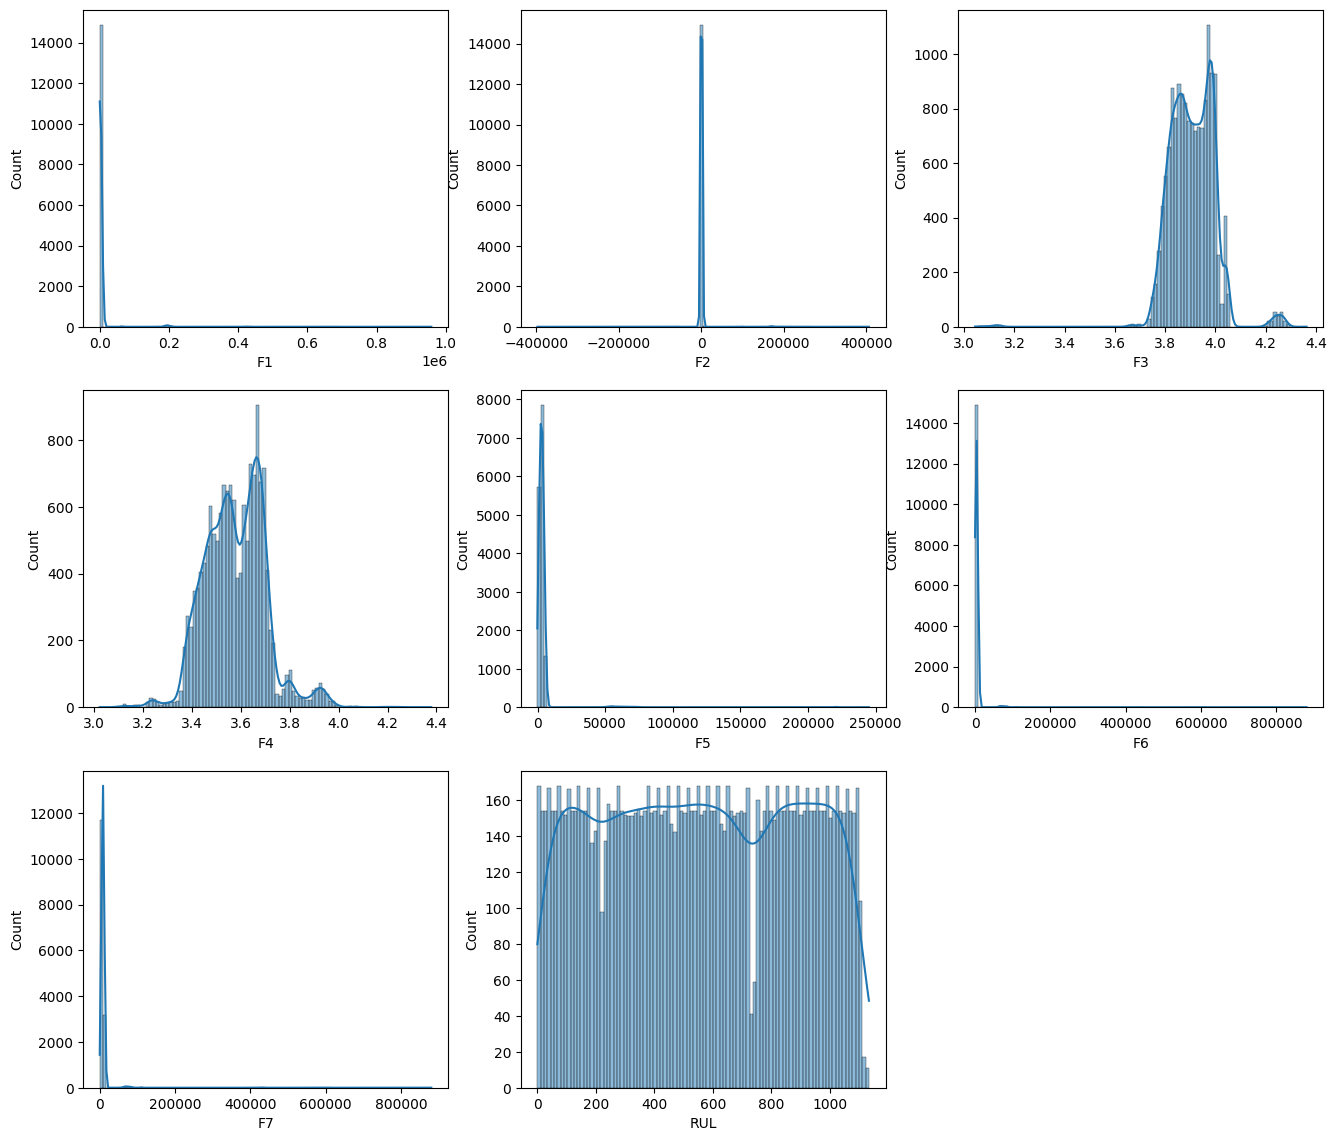

In [9]:
plt.figure(figsize=(16,14))

for i,col in enumerate(new_col_labels):
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=df, bins=100, kde=True)

plt.show()

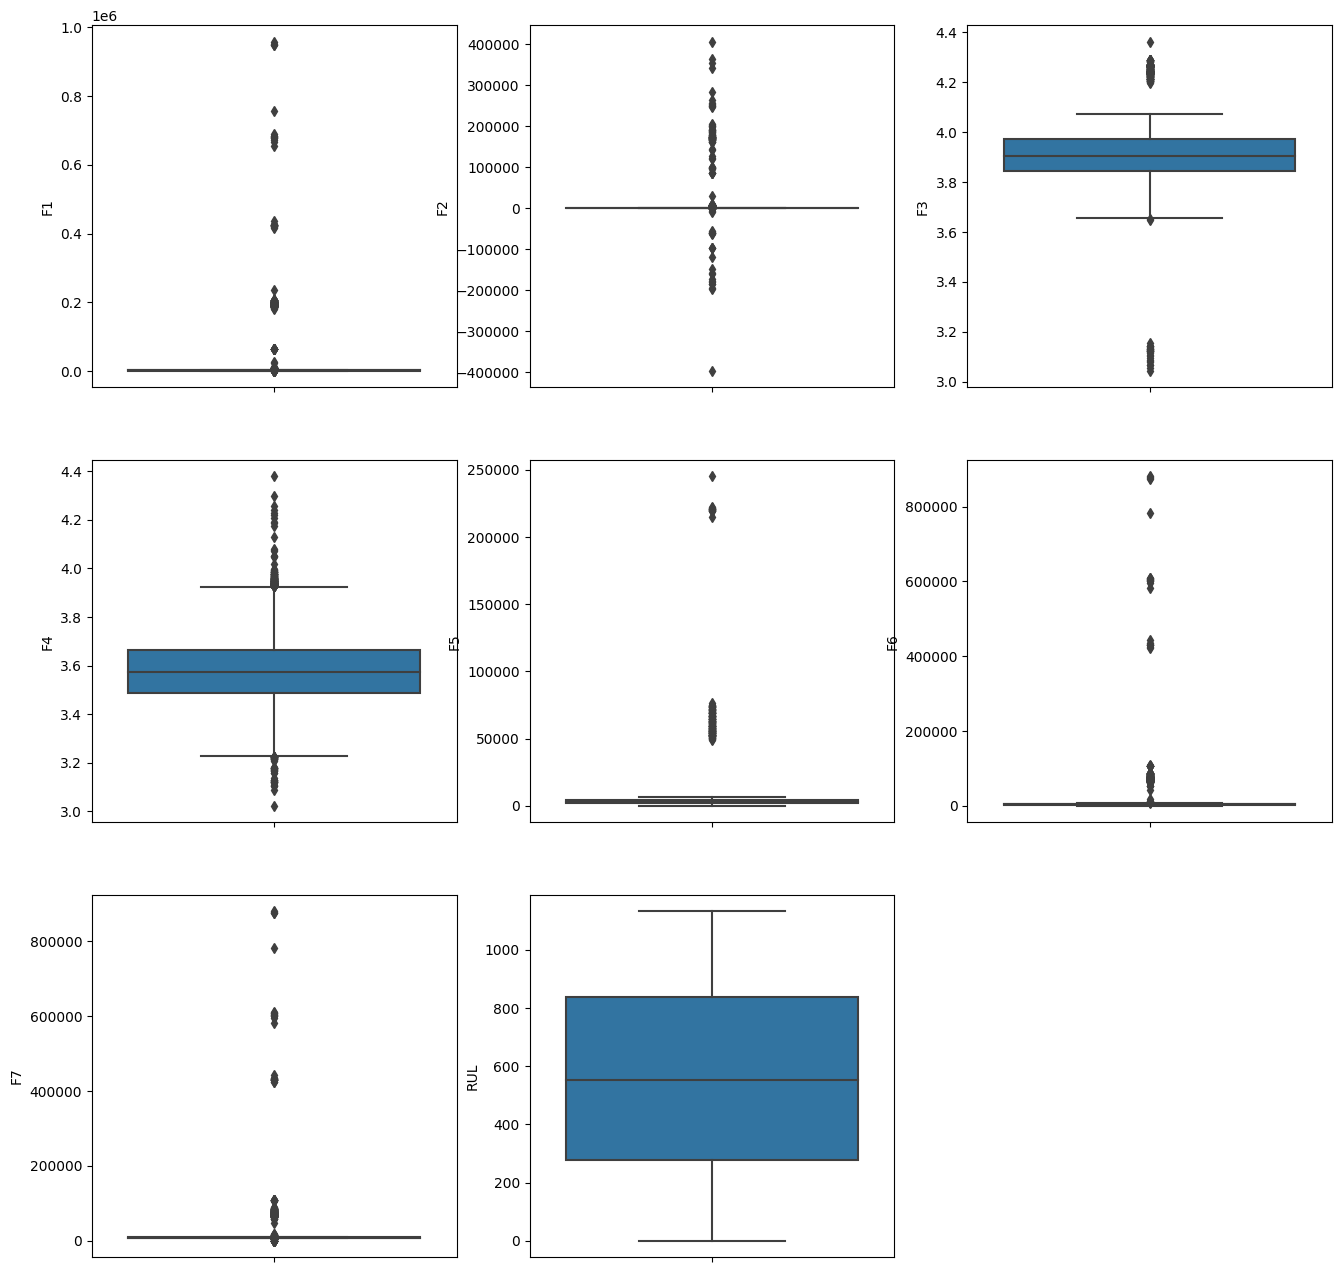

In [10]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=df)

plt.show()

F1, F2, F5, F6, F7 have significant outliers.

An outlier example (line 14) - the values of those 5 features differ by 2 orders of magnitude from the adjacent rows:

In [11]:
df.iloc[10:19]

,F1,F2,F3,F4,F5,F6,F7,RUL
10,3228.58,1135.349333,3.689,3.485,5033.075692,5969.89,5969.89,1101
11,6019.90,1058.279724,4.045,3.475,5053.842846,5980.77,5980.77,1100
12,6026.59,1049.487845,4.047,3.477,5046.429500,5966.82,5966.82,1099
13,6008.07,1065.372059,4.045,3.480,5033.075769,5954.47,5954.47,1098
14,423271.35,168773.265000,4.270,3.108,219923.996000,430028.84,430028.84,1097
15,2261.34,883.200000,4.038,3.901,1949.664000,2922.69,6070.11,1096
16,2259.46,883.199000,4.042,3.373,5181.377000,6161.38,9310.98,1095
17,2256.61,878.400000,4.042,3.374,5181.375000,6154.37,9296.64,1094
18,2252.83,873.601000,4.043,3.374,5174.334000,6147.33,9243.58,1093


 An outlier example (line 7607) - negative value:

In [12]:
df.iloc[7603:7612]

,F1,F2,F3,F4,F5,F6,F7,RUL
7603,2188.81,818.375,4.044,3.384,5002.813,5965.38,9136.38,1049
7604,2186.38,818.438,4.044,3.385,4999.313,5958.31,9101.31,1048
7605,2186.38,818.375,4.045,3.385,4992.375,5958.38,9136.38,1047
7606,2184.00,806.375,4.026,3.705,4956.000,5922.00,9142.00,1046
7607,207013.99,-98271.841,4.272,3.159,73349.980,85080.00,85080.00,1045
7608,11755.36,807.000,4.005,3.380,5250.080,6200.48,9556.67,1044
7609,2184.00,814.400,4.008,3.389,5012.353,5948.35,9188.35,1043
7610,2183.74,816.000,4.009,3.388,5012.318,5948.32,9188.32,1042
7611,2172.00,816.000,4.009,3.389,5005.152,5948.35,9192.90,1041


An outlier example (line 11826) - the values of those 5 features differ by 1-3 orders of magnitude from the adjacent rows:

In [13]:
df.iloc[11822:11831]

,F1,F2,F3,F4,F5,F6,F7,RUL
11822,1017.06,273.371429,3.800,3.674,1457.375000,2096.38,7823.50,41
11823,1014.88,273.500000,3.800,3.673,1452.875000,2096.38,7793.94,40
11824,1008.00,272.457143,3.800,3.675,1448.375000,2060.38,7795.12,39
11825,1012.25,271.542857,3.799,3.676,1443.875000,2060.38,7792.44,38
11826,32.38,42.105263,3.114,3.674,114.250000,8.00,8.00,37
11827,1014.69,271.600000,3.799,3.671,1529.375000,2168.38,7963.75,36
11828,1014.62,271.657143,3.799,3.673,1448.375000,2060.38,7863.06,35
11829,1009.75,269.828571,3.799,3.673,1443.875000,2060.38,7856.69,34
11830,1007.00,268.914286,3.798,3.674,1432.884429,2060.31,7783.56,33


These outliers cannot be interpreted as correct measurements (given the description of the experiment), hence they are ether measurement errors or processing errors. These outliers need removed.

We'll use quantile graphs to derive the cutt-off threshold.

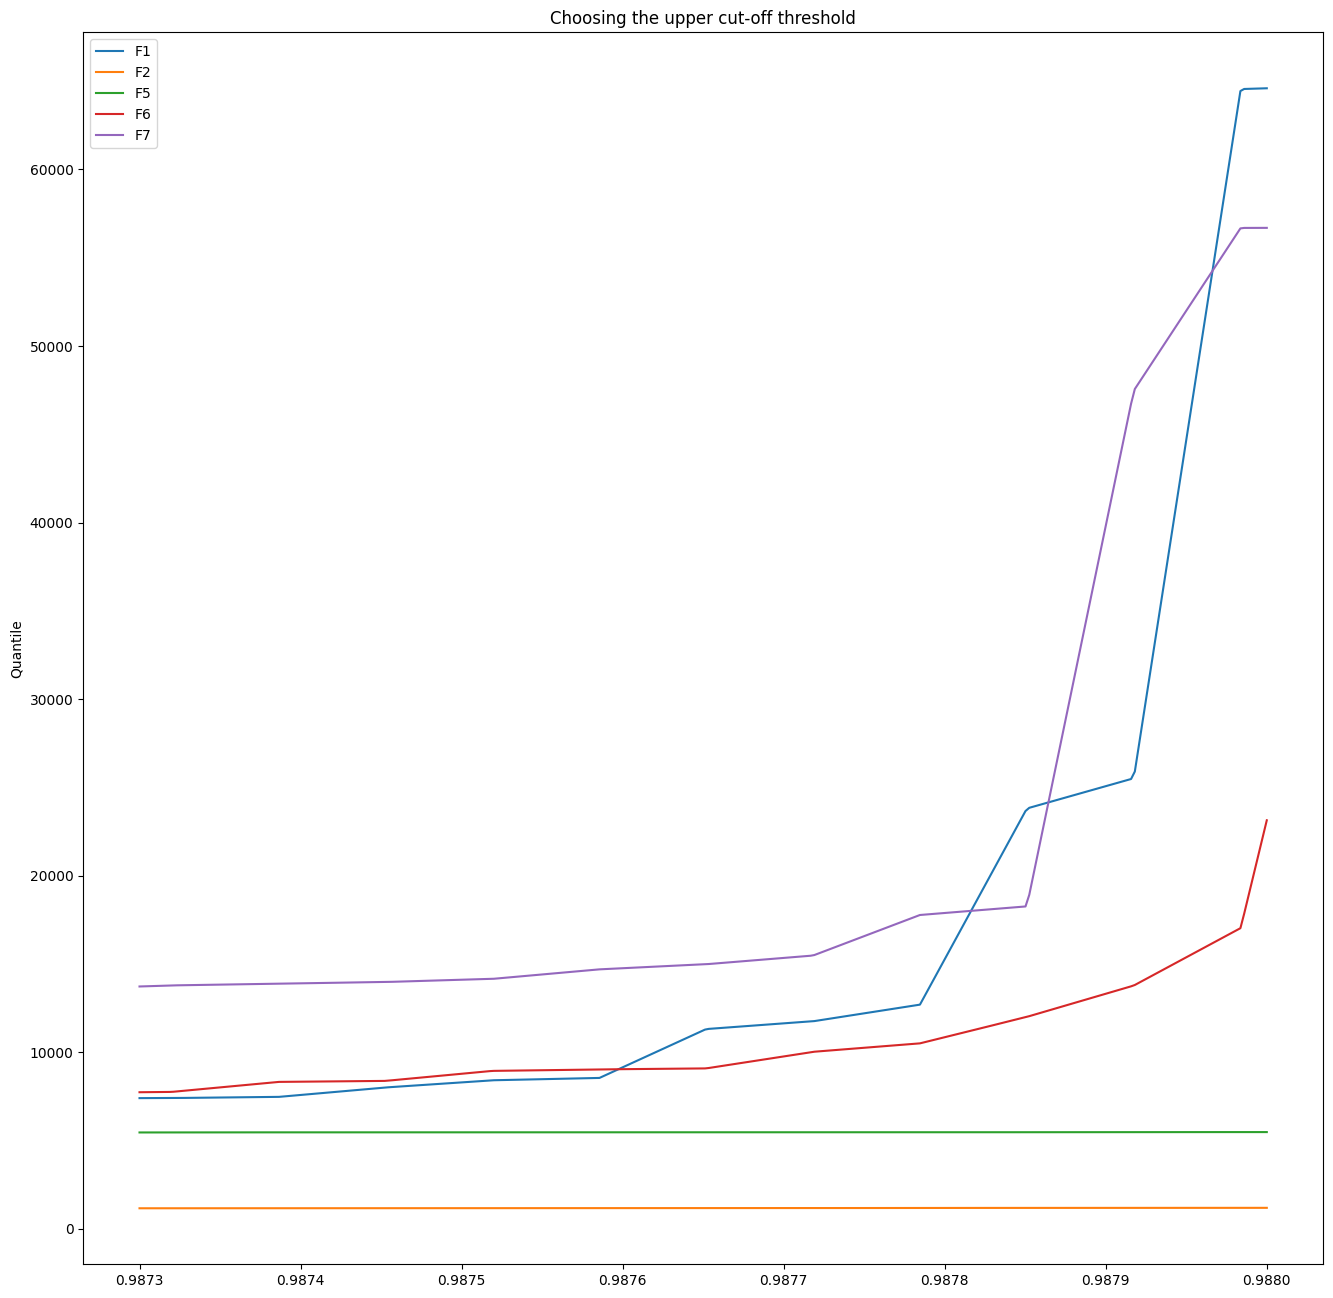

In [14]:
q0 = 0.9873 # values obtained aftes several iterations which I omit here
q1 = 0.9880
pts = 300

plt.figure(figsize=(16,16))
plt.plot(np.linspace(q0, q1, pts), [ df.F1.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F1')
plt.plot(np.linspace(q0, q1, pts), [ df.F2.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F2')
plt.plot(np.linspace(q0, q1, pts), [ df.F5.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F5')
plt.plot(np.linspace(q0, q1, pts), [ df.F6.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F6')
plt.plot(np.linspace(q0, q1, pts), [ df.F7.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F7')
plt.title(label='Choosing the upper cut-off threshold')
plt.ylabel('Quantile')
plt.legend()
plt.show()

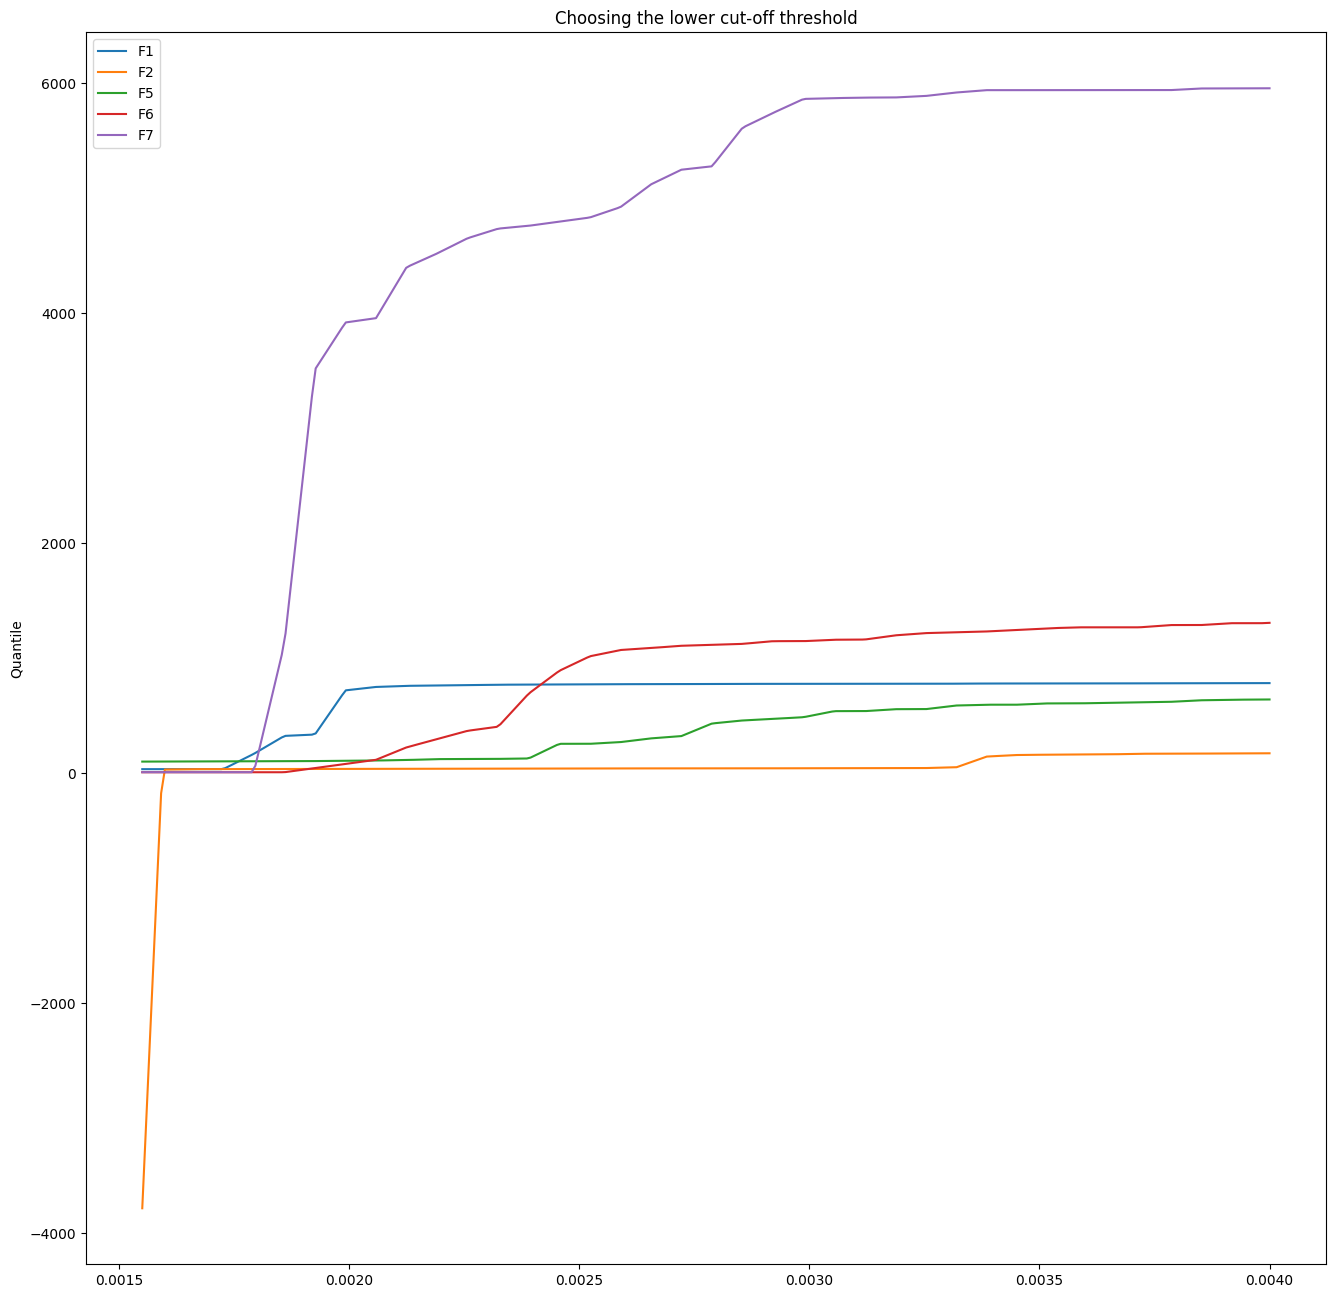

In [15]:
q0 = 0.00155
q1 = 0.0040
pts = 300

plt.figure(figsize=(16,16))
plt.plot(np.linspace(q0, q1, pts), [ df.F1.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F1')
plt.plot(np.linspace(q0, q1, pts), [ df.F2.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F2')
plt.plot(np.linspace(q0, q1, pts), [ df.F5.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F5')
plt.plot(np.linspace(q0, q1, pts), [ df.F6.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F6')
plt.plot(np.linspace(q0, q1, pts), [ df.F7.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F7')
plt.title(label='Choosing the lower cut-off threshold')
plt.ylabel('Quantile')
plt.legend()
plt.show()

Let's cut off by F7 values: keep the values between 3000 and 15000:

In [16]:
dfc = df[3000 < df.F7]
dfc = dfc[df.F7 < 15000]

/tmp/ipykernel_21/1406491950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F7 < 15000]


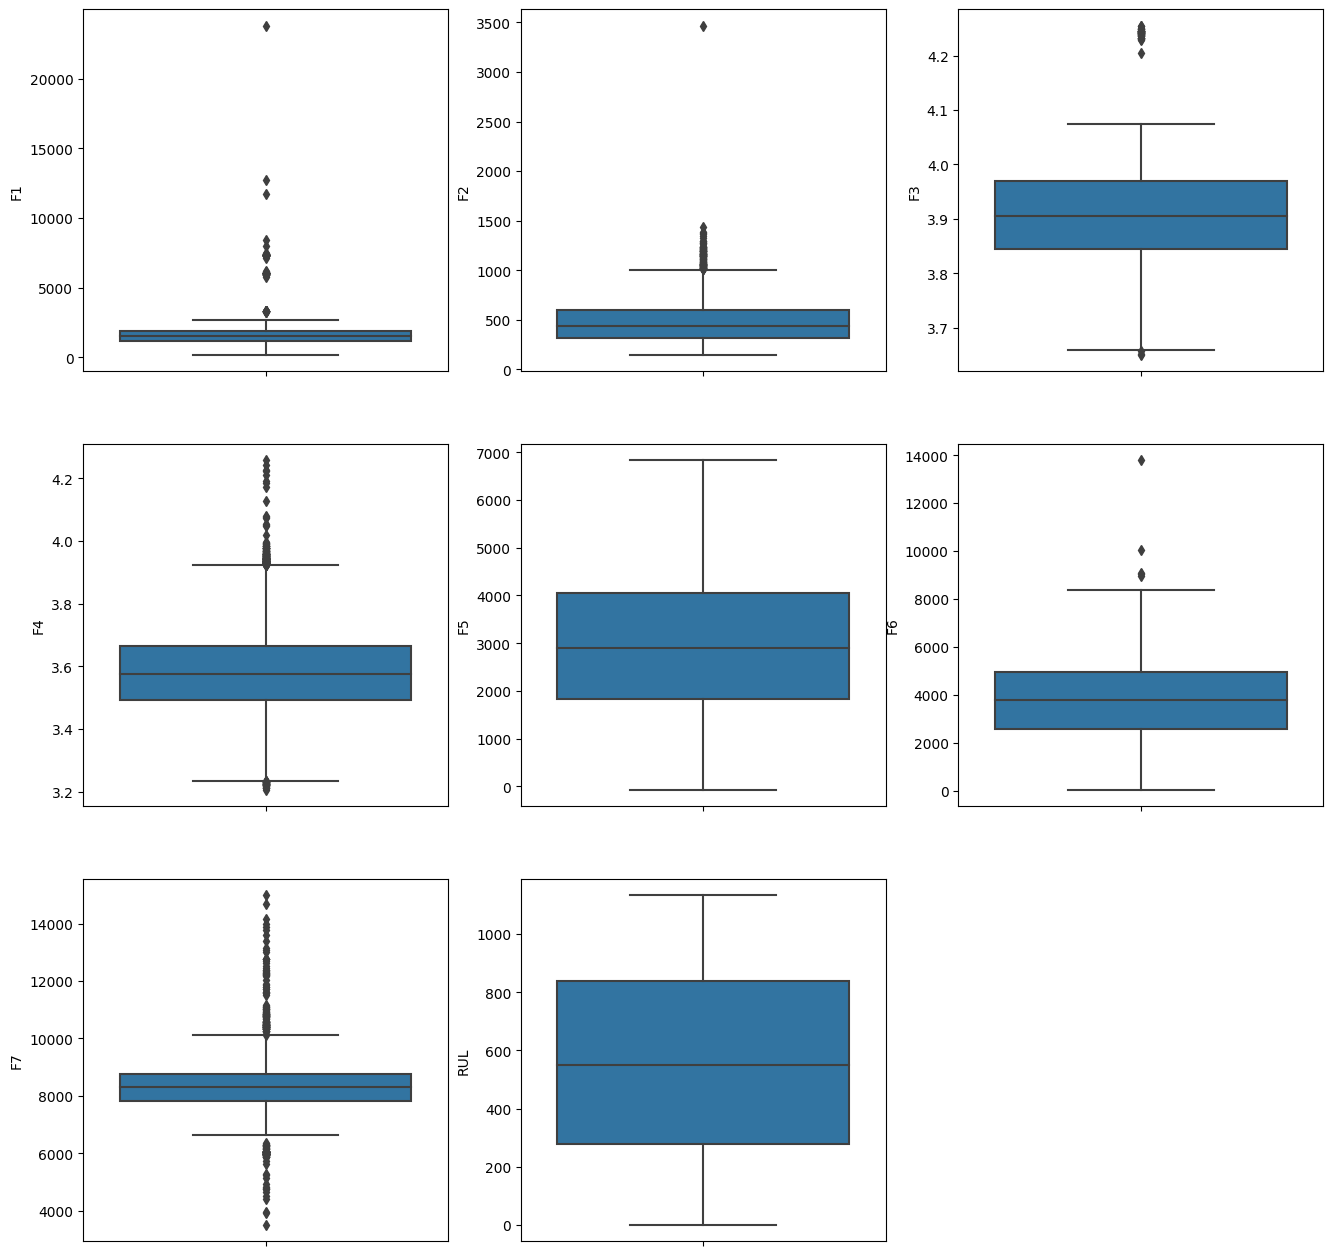

In [17]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=dfc)

plt.show()

Still seening significant outliers in F1 and F2, let's remove them:

In [18]:
dfc = dfc[df.F1 < 10000]
dfc = dfc[df.F2 < 3000]

/tmp/ipykernel_21/2490842494.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F1 < 10000]
/tmp/ipykernel_21/2490842494.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F2 < 3000]


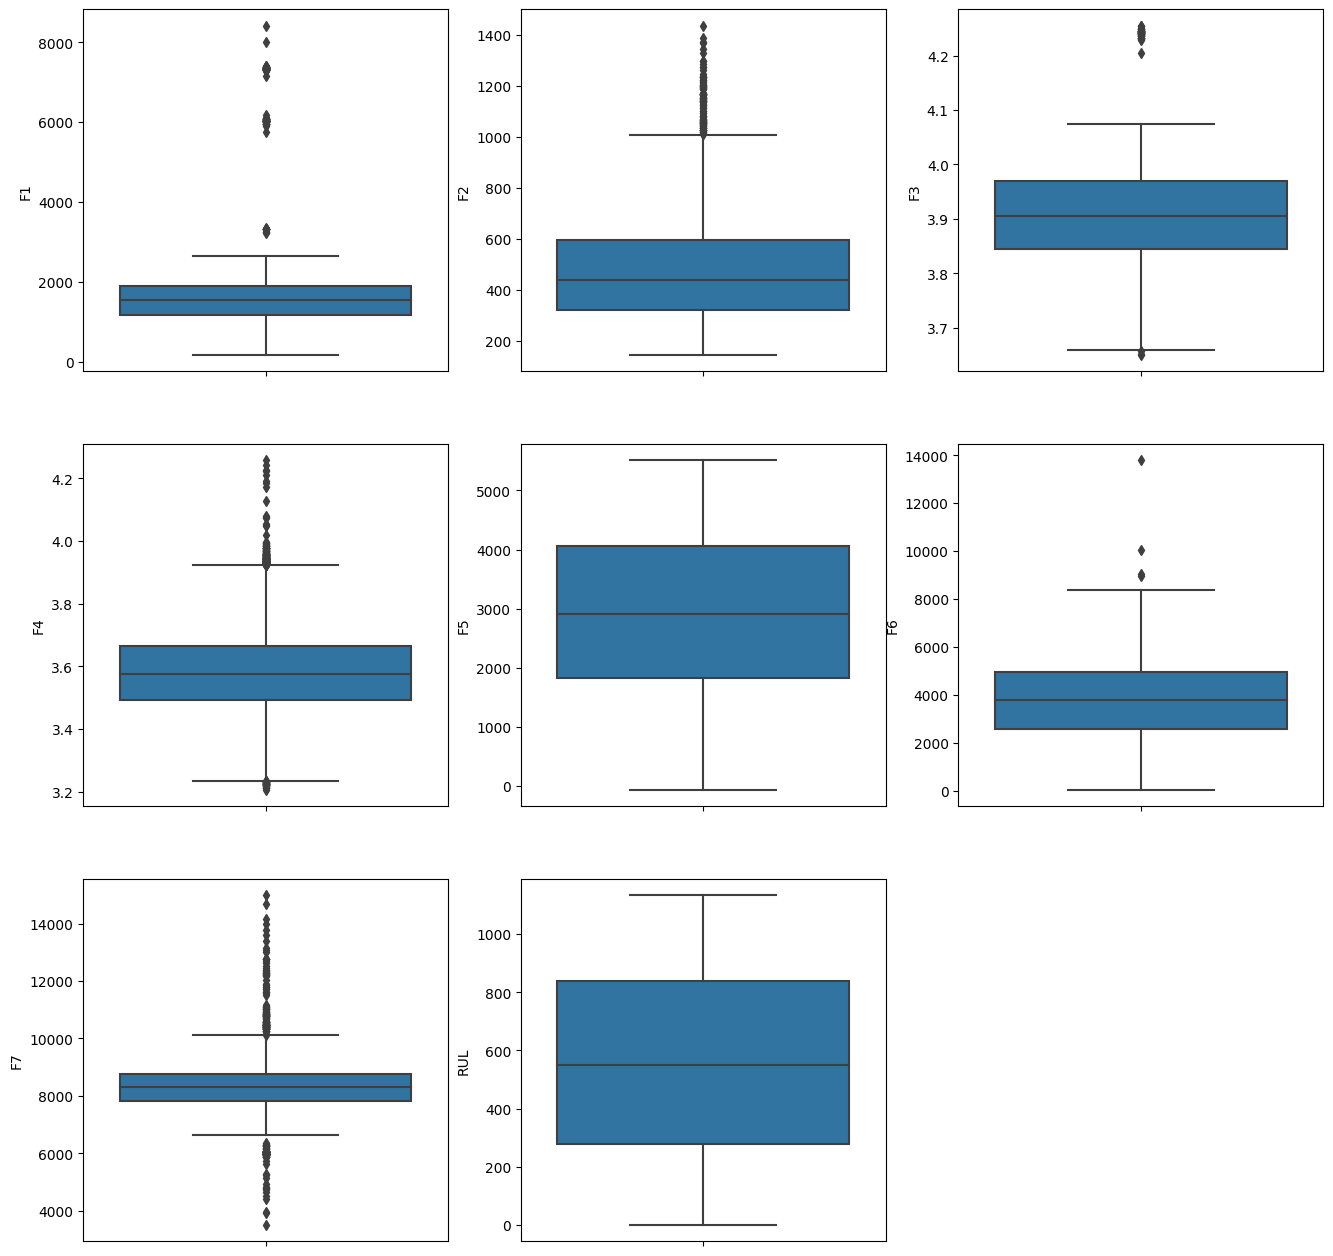

In [19]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=dfc)

plt.show()

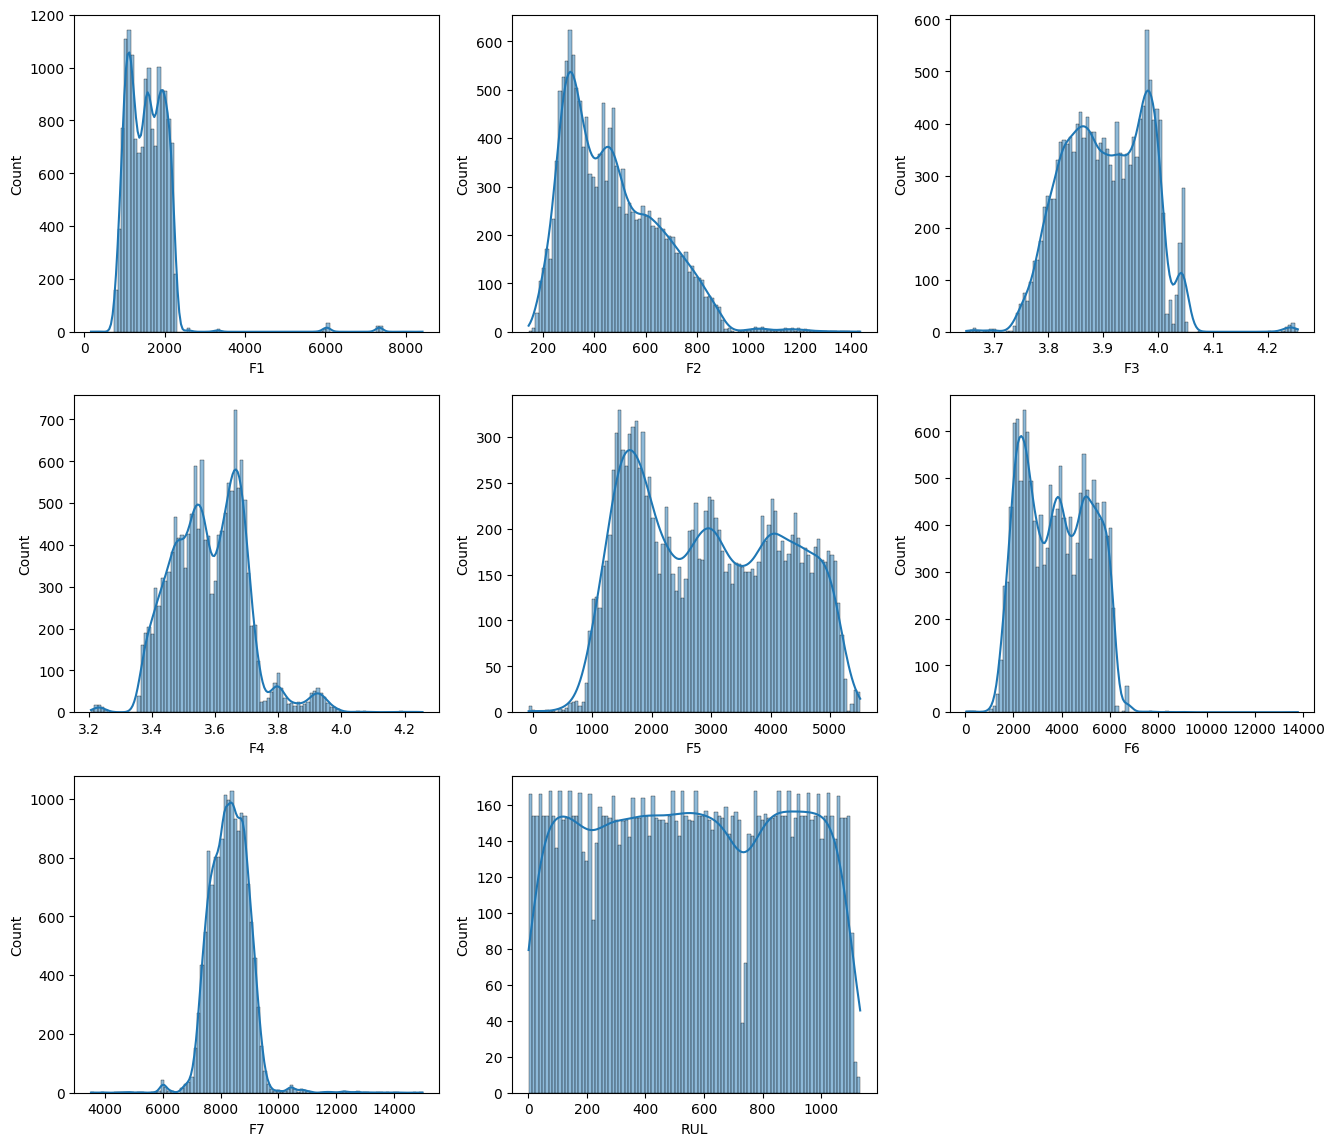

In [20]:
plt.figure(figsize=(16,14))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=dfc, bins=100, kde=True)

plt.show()

In [21]:
print('Removed {:.2f}% or {} rows.'.format(100*(1-dfc.shape[0]/df.shape[0]), df.shape[0] - dfc.shape[0]))
print('Remains {} out of {} rows.'.format(dfc.shape[0], df.shape[0]))

Removed 1.45% or 219 rows.
Remains 14845 out of 15064 rows.


In [22]:
dfc.reset_index(drop=True, inplace=True)

In [23]:
dfc.to_csv('/kaggle/working/Battery_RUL_cleaned.csv')

In [24]:
# dfc = pd.read_csv('/kaggle/working/Battery_RUL_cleaned.csv', index_col=0)

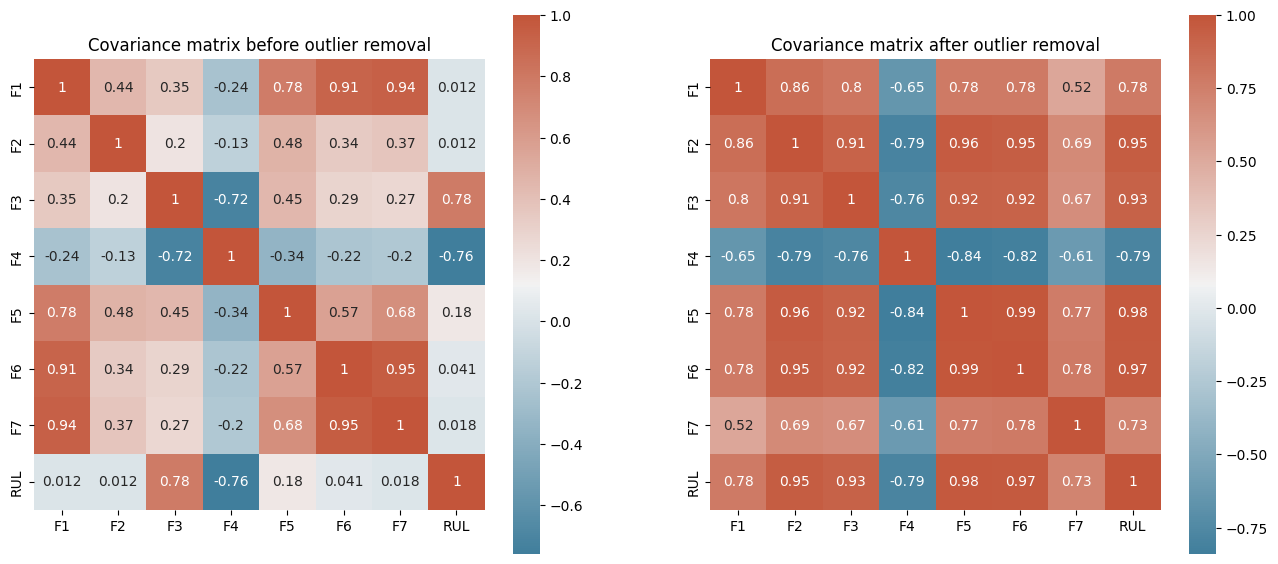

In [25]:
plt.figure(figsize=(16, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplot(1, 2, 1)
plt.title('Covariance matrix before outlier removal')
sns.heatmap(df.corr(), cmap=cmap, annot=True, square=True)
plt.subplot(1, 2, 2)
plt.title('Covariance matrix after outlier removal')
sns.heatmap(dfc.corr(), cmap=cmap, annot=True, square=True)

plt.show()

The features are now strongly intercorrelated!!!

### Normalization

In [26]:
MMS_X = MinMaxScaler()
mms_y = MinMaxScaler()

In [27]:
df_X = pd.DataFrame( MMS_X.fit_transform(dfc.iloc[:,:-1]), columns=list(dfc.columns[:-1]) )
df_y = pd.DataFrame( mms_y.fit_transform(dfc[['RUL']]), columns=['RUL'] )

### PCA

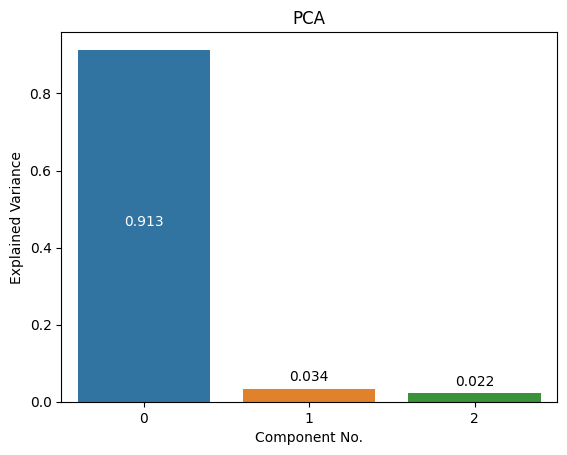

In [28]:
pca = PCA(n_components=3, random_state=0)
pca.fit_transform(df_X)

evr = pca.explained_variance_ratio_
ax=sns.barplot(x=[0,1,2], y=evr)
plt.title('PCA')
plt.xlabel('Component No.')
plt.ylabel('Explained Variance')

ax.text(0, evr[0]/2, round(evr[0],3), color='white', ha='center')
ax.text(1, evr[1] + 0.02, round(evr[1],3), color='black', ha='center')
ax.text(2, evr[2] + 0.02, round(evr[2],3), color='black', ha='center')

plt.show()

Conclusion: the data are practically one-dimensional.

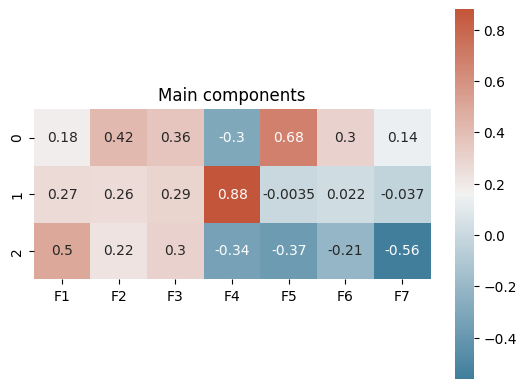

In [29]:
plt.title('Main components')
sns.heatmap(pd.DataFrame(pca.components_, columns=df_X.columns), cmap=cmap, annot=True, square=True)
plt.show()

## Regression

### Dataset to Collect Regressor Metrics

In [30]:
metrics = pd.DataFrame(
    
    index=[
        'Linear','Ridge','kNN'
        ,'RandomForest'
        ,'Polynomial'
        ,'GradientBoosting'
        ,'DenseNN'
    ], 
    
    columns=['R2_best','R2_1_feature','R2_2_features','R2_3_features',
             'MAE_best','MAE_1_feature','MAE_2_features', 'MAE_3_features'])

### A Function for Feature Selection and Cross-Validation

In [31]:
def apply_regressor(reg, X, y):
    
    """
    For the given regressor reg, the function will select best feature sets,
    perform cross-validation and return the following list of metrics:
       
    R2 - best in test
    R2 - best with regression with 1 feature
    R2 - best with regression with 2 features
    R2 - best with regression with 3 features
    MAE - best in test (see note below)
    MAE - with regression with 1 feature
    MAE - with regression with 2 features
    MAE - with regression with 3 features
    
    Note: SequentialFeatureSelector selects by R2. Therefore the MAE values 
    returned by apply_regressor are not necessarily best, they are rather values
    corresponding to the best R2 values.
    
    """
    
    R2_best = 0.0
    R2_1_feature = 0.0
    R2_2_features = 0.0
    R2_3_features = 0.0
    MAE_best = 1e100
    MAE_1_feature = 0.0
    MAE_2_features = 0.0
    MAE_3_features = 0.0
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    print('R2       RMSE    MAE     best features')
    print('-----------------------------------------------')

    n_col = X.shape[1]
    
    for n_f in range(1, n_col + 1):
    
        if n_f == n_col:
            df_Xf = X
        else:    
            sfs = SequentialFeatureSelector(reg, n_features_to_select=n_f)
            df_Xf = sfs.fit_transform(X, y)
    
        cv=cross_validate(reg, df_Xf, y, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], cv=kf)
    
        if n_f == n_col:
            best_f = '[ALL]'
        else:
            best_f = sfs.get_support(indices=True) + 1
    
        R2 = cv['test_r2'].mean()
        RMSE = -cv['test_neg_root_mean_squared_error'].mean()
        MAE = -cv['test_neg_mean_absolute_error'].mean()
        
        if n_f == 1:
            R2_1_feature = R2
            MAE_1_feature = MAE
        
        if n_f == 2:
            R2_2_features = R2
            MAE_2_features = MAE
            
        if n_f == 3:
            R2_3_features = R2
            MAE_3_features = MAE
            
        if R2 > R2_best: R2_best = R2
        if MAE < MAE_best: MAE_best = MAE
    
        # print(cv['test_r2'].std())
    
        print('{:.4f}   {:.2f}   {:.2f}  '.format(R2, RMSE, MAE), best_f)
        
    return [ R2_best, R2_1_feature, R2_2_features, R2_3_features, MAE_best, MAE_1_feature, MAE_2_features, MAE_3_features ]

Note: SequentialFeatureSelector selects by R2. Therefore the MAE values returned by apply_regressor are not necessarily best, they are rather values corresponding to the best R2 values.

### Linear Regression

In [32]:
metrics.loc['Linear'] = apply_regressor(LinearRegression(fit_intercept=True), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9553   67.85   42.86   [5]
0.9595   64.57   41.89   [4 5]
0.9635   61.43   42.71   [3 4 5]
0.9645   60.53   43.53   [3 4 5 7]
0.9649   60.22   43.41   [3 4 5 6 7]
0.9651   60.04   44.10   [2 3 4 5 6 7]
0.9653   59.86   44.75   [ALL]


### Ridge Regression (L2-regularization)

In [33]:
metrics.loc['Ridge'] = apply_regressor(Ridge(alpha=3.0, fit_intercept=True), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9553   67.87   42.88   [5]
0.9594   64.70   41.69   [4 5]
0.9633   61.54   42.69   [3 4 5]
0.9642   60.79   43.21   [3 4 5 7]
0.9646   60.43   43.05   [3 4 5 6 7]
0.9646   60.48   43.06   [1 3 4 5 6 7]
0.9651   60.10   44.82   [ALL]


### k-Nearest Neighbors

kNN with neighbors from 2 to 6:

In [34]:
kNN1 = apply_regressor(KNeighborsRegressor(n_neighbors=2), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9681   57.47   39.88   [1]
0.9729   52.99   35.24   [1 6]
0.9762   49.66   32.80   [1 5 6]
0.9862   37.75   20.74   [1 4 5 6]
0.9925   27.80   12.36   [1 2 4 5 6]
0.9950   22.66   8.03   [1 2 3 4 5 6]
0.9963   19.46   6.11   [ALL]


In [35]:
kNN2 = apply_regressor(KNeighborsRegressor(n_neighbors=3), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9712   54.58   38.30   [1]
0.9759   49.92   33.72   [1 6]
0.9781   47.60   32.26   [1 5 6]
0.9866   37.16   21.77   [1 4 5 6]
0.9926   27.64   13.35   [1 2 4 5 6]
0.9952   22.23   8.76   [1 2 3 4 5 6]
0.9965   19.10   6.59   [ALL]


In [36]:
kNN3 = apply_regressor(KNeighborsRegressor(n_neighbors=4), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9727   53.10   37.44   [1]
0.9773   48.47   33.12   [1 6]
0.9790   46.62   31.99   [1 5 6]
0.9866   37.21   22.83   [1 4 5 6]
0.9924   27.97   14.31   [1 2 4 5 6]
0.9952   22.31   9.41   [1 2 3 4 5 6]
0.9964   19.30   7.04   [ALL]


In [37]:
kNN4 = apply_regressor(KNeighborsRegressor(n_neighbors=5), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9737   52.17   36.79   [1]
0.9782   47.52   32.64   [1 6]
0.9796   45.93   31.89   [1 5 6]
0.9857   38.40   24.40   [1 2 5 6]
0.9921   28.49   15.29   [1 2 4 5 6]
0.9950   22.73   10.27   [1 2 3 4 5 6]
0.9963   19.48   7.62   [ALL]


In [38]:
kNN5 = apply_regressor(KNeighborsRegressor(n_neighbors=6), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9742   51.63   36.45   [1]
0.9786   47.09   32.46   [1 6]
0.9799   45.65   31.93   [1 5 6]
0.9859   38.13   24.73   [1 4 5 6]
0.9917   29.28   16.33   [1 2 4 5 6]
0.9948   23.28   11.12   [1 2 3 4 5 6]
0.9962   19.90   8.19   [ALL]


In [39]:
kNN_all = [ kNN1, kNN2, kNN3, kNN4, kNN5 ]
kNN_R2_best = np.argmax( [ L[0] for L in kNN_all  ] )
print(kNN_R2_best)

1


In [40]:
metrics.loc['kNN'] = kNN_all[kNN_R2_best]

### Random Forest

Random Forest with different number of trees:

In [41]:
# Important! The cell works very slow!
RFR1 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=60), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9696   56.11   38.53   [1]
0.9784   47.30   32.03   [1 6]
0.9812   44.08   29.90   [1 5 6]
0.9912   30.10   18.11   [1 3 5 6]
0.9940   24.98   14.60   [1 2 3 5 6]
0.9956   21.33   11.43   [1 2 3 4 5 6]
0.9966   18.70   9.23   [ALL]


In [42]:
# Important! The cell works very slow!
#RFR2 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=100), df_X, dfc.RUL)

In [43]:
# Important! The cell works very slow!
#RFR3 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=200), df_X, dfc.RUL)

In [44]:
# Important! The cell works very slow!
#RFR4 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=500), df_X, dfc.RUL)

In [45]:
# Important! The cell works very slow!
#RFR5 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=1000), df_X, dfc.RUL)

In [46]:
#RFR_all = [ RFR1, RFR2, RFR3, RFR4, RFR5 ]
#RFR_R2_best = np.argmax( [ L[0] for L in RFR_all  ] )
#print(RFR_R2_best)

In [47]:
metrics.loc['RandomForest'] = RFR1 # RFR_all[RFR_R2_best]

### Polynomial Regression

In [48]:
poly = PolynomialFeatures(7, include_bias=False)
dfp = df_X.copy()
dfp = poly.fit_transform(dfp)
dfp = pd.DataFrame(dfp)
dfp.shape

(14845, 3431)

New feature correlation check:

In [49]:
lst = (dfp.corrwith(df_y.iloc[:,0]).abs().sort_values()).reset_index()
of = poly.get_feature_names_out()
for i in lst.index:
    lst.loc[i,'terms'] = of[lst.iloc[i,0]]

lst.tail(15)

,index,0,terms
3416,2,0.928035,F3
3417,110,0.929082,F5^2 F6
3418,112,0.930110,F5 F6^2
3419,33,0.933703,F6 F7
3420,111,0.934943,F5^2 F7
3421,113,0.935262,F5 F6 F7
3422,32,0.946105,F6^2
3423,22,0.949746,F3 F5
3424,23,0.950120,F3 F6
3425,1,0.950237,F2


F5 still has the best correlation, the new features could not beat it.

Let's add 3 best new features:

In [50]:
dfpoly = df_X.copy()
dfpoly['F8'] = df_X.F5*df_X.F6
dfpoly['F9'] = df_X.F5**2
dfpoly['F10'] = df_X.F5*df_X.F7

In [51]:
metrics.loc['Polynomial'] = apply_regressor(LinearRegression(fit_intercept=True), dfpoly, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9553   67.85   42.86   [5]
0.9595   64.57   41.89   [4 5]
0.9635   61.43   42.71   [3 4 5]
0.9641   60.86   42.84   [ 3  4  5 10]
0.9647   60.42   43.95   [ 2  3  4  5 10]
0.9653   59.85   43.72   [ 2  3  4  5  9 10]
0.9654   59.80   43.66   [ 2  3  4  5  6  9 10]
0.9658   59.42   44.43   [ 1  2  3  4  5  6  9 10]
0.9658   59.43   44.41   [ 1  2  3  4  5  6  8  9 10]
0.9667   58.64   44.28   [ALL]


Conclusion: there is not much of non-linearity.

### Gradient Boosting

Estimate the optimal value of learning_rate with the full feature set:

In [52]:
# Careful! The cell works slow!

lr_best = 0
R2_best = 0

for i in range(200):
    learning_rate=0.01 + i/200
    cv=cross_validate(GradientBoostingRegressor(learning_rate=learning_rate), 
               df_X, dfc.RUL, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
               cv=KFold(n_splits=5, shuffle=True, random_state=0))
    R2 = cv['test_r2'].mean()
    print('{}  {:.4f}   {:.2f}   {:.2f}  '.format(i,
            R2, 
            -cv['test_neg_root_mean_squared_error'].mean(),
            -cv['test_neg_mean_absolute_error'].mean()))
    if R2 > R2_best:
        R2_best = R2
        lr_best = learning_rate
        
print('Best R2: {} with learning_rate = {}'.format(R2_best, lr_best))

0  0.8422   127.77   108.12  
1  0.9284   86.06   71.83  
2  0.9611   63.42   52.50  
3  0.9736   52.24   42.18  
4  0.9786   47.00   36.70  
5  0.9808   44.58   34.00  
6  0.9818   43.38   32.59  
7  0.9822   42.84   31.94  
8  0.9827   42.31   31.43  
9  0.9831   41.79   31.03  
10  0.9832   41.62   30.80  
11  0.9834   41.45   30.64  
12  0.9835   41.33   30.49  
13  0.9838   40.97   30.24  
14  0.9840   40.73   30.03  
15  0.9841   40.52   29.87  
16  0.9846   39.95   29.44  
17  0.9846   39.90   29.39  
18  0.9850   39.45   29.02  
19  0.9852   39.18   28.79  
20  0.9854   38.88   28.57  
21  0.9856   38.59   28.44  
22  0.9856   38.55   28.28  
23  0.9861   37.90   27.87  
24  0.9862   37.71   27.68  
25  0.9862   37.83   27.65  
26  0.9863   37.57   27.60  
27  0.9867   37.15   27.24  
28  0.9868   36.88   27.10  
29  0.9868   36.98   27.06  
30  0.9869   36.83   26.99  
31  0.9873   36.26   26.61  
32  0.9872   36.44   26.57  
33  0.9873   36.30   26.58  
34  0.9872   36.37   2

In [53]:
# Attention! The cell works slow!
#GBR1 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best - 0.02), df_X, dfc.RUL)

In [54]:
# Attention! The cell works slow!
#GBR2 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best - 0.01), df_X, dfc.RUL)

In [55]:
# Attention! The cell works slow!
GBR3 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best), df_X, dfc.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9756   50.26   35.43   [1]
0.9786   47.04   33.70   [1 6]
0.9787   46.88   33.73   [1 5 6]
0.9811   44.17   31.40   [1 4 5 6]
0.9875   36.02   25.75   [1 3 4 5 6]
0.9889   33.94   24.19   [1 2 3 4 5 6]
0.9908   30.82   21.37   [ALL]


In [56]:
# Attention! The cell works slow!
#GBR4 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best + 0.01), df_X, dfc.RUL)

In [57]:
# Attention! The cell works slow!
#GBR5 = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best + 0.02), df_X, dfc.RUL)

In [58]:
#GBR_all = [ GBR1, GBR2, GBR3, GBR4, GBR5 ]
#GBR_R2_best = np.argmax( [ L[0] for L in GBR_all  ] )
#print(GBR_R2_best)

In [59]:
metrics.loc['GradientBoosting'] = GBR3 #GBR_all[GBR_R2_best]

## Dense Neural Network

In [60]:
def plot_loss(history, opt, act):
    plt.plot(history.history['loss'], label='loss')
    
    try:
        plt.plot(history.history['val_loss'], label='val_loss')
    except:
        print('No validation data')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Optimizer: {}, activation function: {}'.format(opt, act))
    plt.grid(True)

### Optimizer Selection

100 epochs, 2 hidden layers with 35 neurons each, tanh and relu.
(Tests are omitted here.)

Conclusions:

- Adadelta - no convergence over 100 epochs (negative R2), several thousand epochs are needed, the result is still worse than Adam

- Adagrad - unstable results, large dispersion of R2

- Adam - consistently R2 > 0.97, quick convergence (40 epochs) - with relu. Worse with tanh: R2 < 0.97

- Adamax - almost as good as Adam

- Ftrl - no convergence over 100 epochs (negative R2), several thousand epochs are needed, the result is still worse than Adam

- Nadam - R2 comparable to Adam, but sometimes there are pulsations, convergence visually slower

- RMSprop - slightly worse than Adamax, pulsations

- SGD - R2 < 0.96, convergence worse than Adam

All the optimizers show better results with relu, than with tanh

The leader - Adam, 2nd place - Adamax.

116/116 [==============================] - 0s 1ms/step
0.9769363343146721 48.59915741527064 37.593441663004846


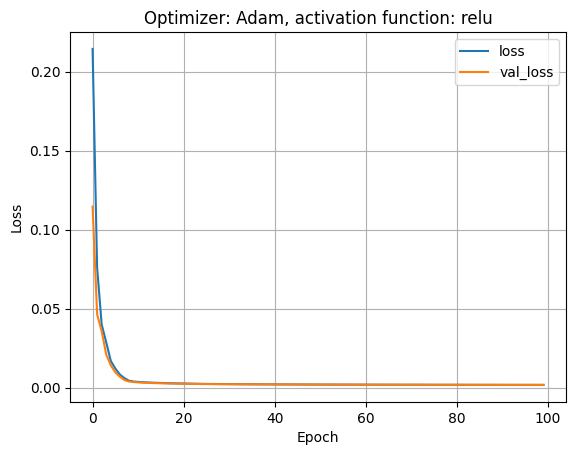

In [61]:
model = Sequential()
opt = 'Adam'
act = 'relu'
model.add(Dense(35, input_dim=7, activation=act))
model.add(Dense(35, activation=act))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=opt)

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, shuffle=True, random_state=0)
hist = model.fit(df_X_train, df_y_train, epochs=100, validation_split=0.2, batch_size=1000, verbose=0)
y_pred = model.predict(df_X_test)

df_y_test_inv = mms_y.inverse_transform(df_y_test)
y_pred_inv = mms_y.inverse_transform(y_pred)

print(r2_score(df_y_test, y_pred),
    mean_squared_error(df_y_test_inv, y_pred_inv)**0.5,
    mean_absolute_error(df_y_test_inv, y_pred_inv))

plot_loss(hist, opt, act)

From now on only use Adam and relu.

### A Function for Cross-Validation

In [62]:
def cross_val(X, y, mmsy):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    R2_list = []
    RMSE_list = []
    MAE_list = []
    
    for i, (train_index, test_index) in enumerate(kf.split( X )):
        
        model = Sequential()
        model.add(Dense(50, input_dim=X.shape[1], activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(y.shape[1], activation='linear'))
        model.compile(loss='mse', optimizer='Adam')

        hist = model.fit(X.iloc[train_index], y.iloc[train_index], epochs=70, validation_split=0.0, batch_size=1000, verbose=0)
        y_pred = model.predict(X.iloc[test_index])
    
        y_test_inv = mmsy.inverse_transform(y.iloc[test_index])
        y_pred_inv = mmsy.inverse_transform(y_pred)
    
        R2 = r2_score(y.iloc[test_index], y_pred)
        RMSE = mean_squared_error(y_test_inv, y_pred_inv)**0.5
        MAE = mean_absolute_error(y_test_inv, y_pred_inv)
        
        R2_list.append(R2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        
    return [ np.mean(R2_list), np.mean(RMSE_list), np.mean(MAE_list) ]

### Feature Selection

In [63]:
best_R2 = [0,0,0,0,0,0,0]
best_MAE = [1e10,1e10,1e10,1e10,1e10,1e10,1e10]
best_features = [ [],[],[],[],[],[],[] ]

for i in range(1,128):
    
    print(i)
    
    X = df_X.iloc[:,[ 1 == (i // 2**n) % 2 for n in range(0,7)]]
    n_features = len(X.columns)
    
    (R2, _, MAE) = cross_val(X, df_y, mms_y)
    
    if R2 > best_R2[n_features - 1]:
        best_R2[n_features - 1] = R2
        best_features[n_features - 1] = list(X.columns)
        #if best_MAE[n_features - 1] > MAE:
        best_MAE[n_features - 1] = MAE
    

1
93/93 [==============================] - 0s 1ms/step
2
93/93 [==============================] - 0s 1ms/step
3
93/93 [==============================] - 0s 1ms/step
4
93/93 [==============================] - 0s 1ms/step
5
93/93 [==============================] - 0s 1ms/step
6
93/93 [==============================] - 0s 1ms/step
7
93/93 [==============================] - 0s 1ms/step
8
93/93 [==============================] - 0s 1ms/step
9
93/93 [==============================] - 0s 1ms/step
10
93/93 [==============================] - 0s 1ms/step
11
93/93 [==============================] - 0s 1ms/step
12
93/93 [==============================] - 0s 1ms/step
13
93/93 [==============================] - 0s 1ms/step
14
93/93 [==============================] - 0s 1ms/step
15
93/93 [==============================] - 0s 1ms/step
16
93/93 [==============================] - 0s 1ms/step
17
93/93 [==============================] - 0s 1ms/step
18
93/93 [==============================] - 0s 1ms/step
1

In [64]:
best_R2

[0.9756121195396587,
 0.9752275969495467,
 0.9774411426448391,
 0.9775655410133591,
 0.9780914260715295,
 0.9793795477889755,
 0.9783389119076362]

In [65]:
print('Best R2 value is attained with {} features.'.format(
    1 + np.argmax(best_R2)))

Best R2 value is attained with 6 features.


With all the other regressors, the best R2 value is attained with the full
set of features (7).

In [66]:
best_MAE

[36.27308780545536,
 36.443965129203455,
 36.906501907643225,
 35.369381444371484,
 35.15564948119733,
 34.98852222508234,
 35.799725747965695]

In [67]:
best_features

[['F1'],
 ['F1', 'F7'],
 ['F2', 'F3', 'F5'],
 ['F1', 'F3', 'F6', 'F7'],
 ['F1', 'F3', 'F4', 'F5', 'F7'],
 ['F2', 'F3', 'F4', 'F5', 'F6', 'F7'],
 ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']]

In [68]:
metrics.loc['DenseNN'] = [
    max(best_R2), best_R2[0], best_R2[1], best_R2[2], 
    min(best_MAE), best_MAE[0], best_MAE[1], best_MAE[2]]

## Regressor Comparison

In [69]:
metrics

,R2_best,R2_1_feature,R2_2_features,R2_3_features,MAE_best,MAE_1_feature,MAE_2_features,MAE_3_features
Linear,0.965325,0.955305,0.959547,0.963458,41.890696,42.862455,41.890696,42.709987
Ridge,0.965053,0.955281,0.959377,0.963327,41.688289,42.879856,41.688289,42.694885
kNN,0.996457,0.971175,0.975906,0.978096,6.592006,38.295498,33.720467,32.255956
RandomForest,0.996614,0.969552,0.978368,0.98121,9.230304,38.531221,32.026152,29.895593
Polynomial,0.966741,0.955305,0.959547,0.963458,41.890696,42.862455,41.890696,42.709987
GradientBoosting,0.990813,0.975557,0.9786,0.978744,21.365446,35.433984,33.701959,33.727206
DenseNN,0.97938,0.975612,0.975228,0.977441,34.988522,36.273088,36.443965,36.906502


In [70]:
metrics.to_csv('/kaggle/working/regressor_metrics.csv')

In [71]:
# metrics = pd.read_csv('/kaggle/working/regressor_metrics.csv', index_col=0)

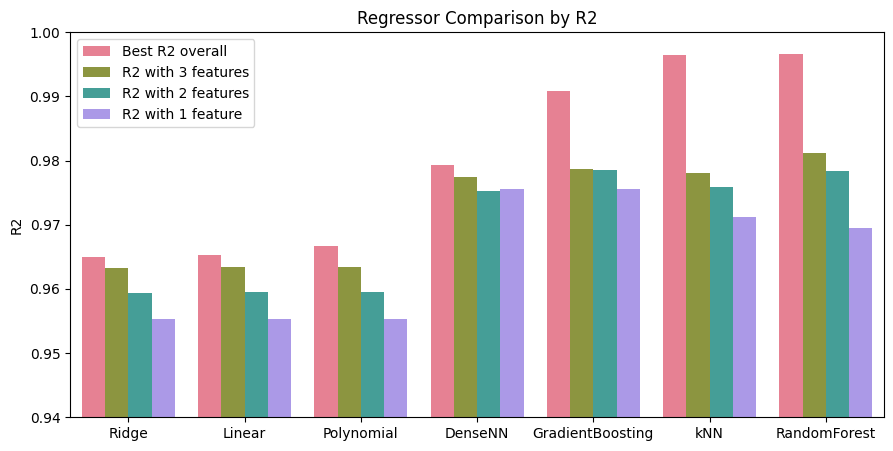

In [72]:
# R2

metrics_sorted = metrics.sort_values('R2_best')

metrics_melted = pd.melt(
    metrics_sorted.reset_index()[['index','R2_best','R2_3_features','R2_2_features','R2_1_feature']],
    id_vars='index')

bar_labels_r2 = {
        'R2_best' : 'Best R2 overall',
        'R2_1_feature' : 'R2 with 1 feature',
        'R2_2_features' : 'R2 with 2 features',
        'R2_3_features' : 'R2 with 3 features'
    }
    
metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_r2[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('R2')
plt.title('Regressor Comparison by R2')
plt.ylim(0.94, 1)
plt.show()

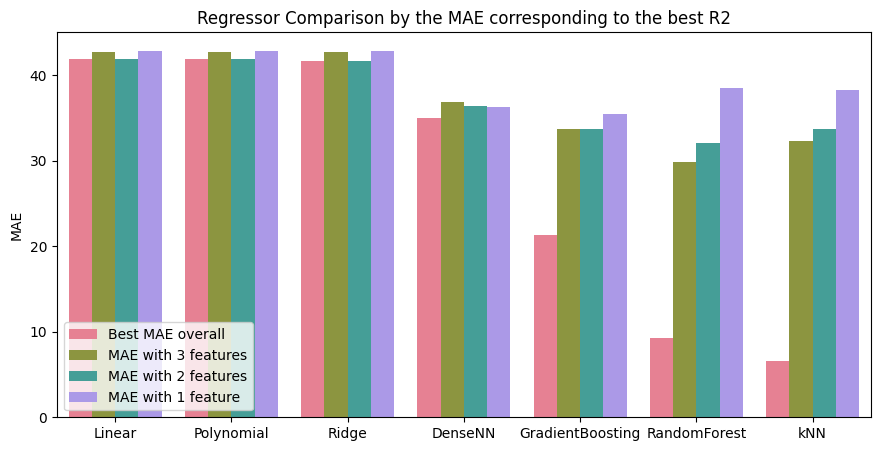

In [73]:
# MAE

metrics_sorted = metrics.sort_values('MAE_best', ascending=False)

metrics_melted = pd.melt(
    metrics_sorted.reset_index()[['index','MAE_best','MAE_3_features','MAE_2_features','MAE_1_feature']],
    id_vars='index')

bar_labels_mae = {
        'MAE_best' : 'Best MAE overall',
        'MAE_1_feature' : 'MAE with 1 feature',
        'MAE_2_features' : 'MAE with 2 features',
        'MAE_3_features' : 'MAE with 3 features'
    }
    
metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_mae[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='lower left')
plt.xlabel('')
plt.ylabel('MAE')
plt.title('Regressor Comparison by the MAE corresponding to the best R2')
plt.show()

## Dense Neural Network for My App
### (TensorFlow Serving Server and C++ Client)

Using all 7 features seems redundant. For the app, let's train a network which will use just 3 features \[F1, F4, F7\] for predictions, and predict not only RUL but also all the remaining features.

In [74]:
app_MMS_X = MinMaxScaler()
app_mms_y = MinMaxScaler()

In [75]:
app_X_cols = ['F1', 'F4', 'F7']
app_y_cols = list(set(dfc.columns) - set(app_X_cols))
app_y_cols.sort()
print('y = ', app_y_cols)

app_X = pd.DataFrame( app_MMS_X.fit_transform(dfc[app_X_cols]), columns=[app_X_cols] )
app_y = pd.DataFrame( app_mms_y.fit_transform(dfc[app_y_cols]), columns=[app_y_cols] )

y =  ['F2', 'F3', 'F5', 'F6', 'RUL']


In [76]:
cross_val(app_X, app_y, app_mms_y)

93/93 [==============================] - 0s 1ms/step


[0.9591127024749035, 120.46092623221966, 38.26845321342798]

93/93 [==============================] - 0s 1ms/step
R2=0.9738  RMSE=95.98  MAE=33.01


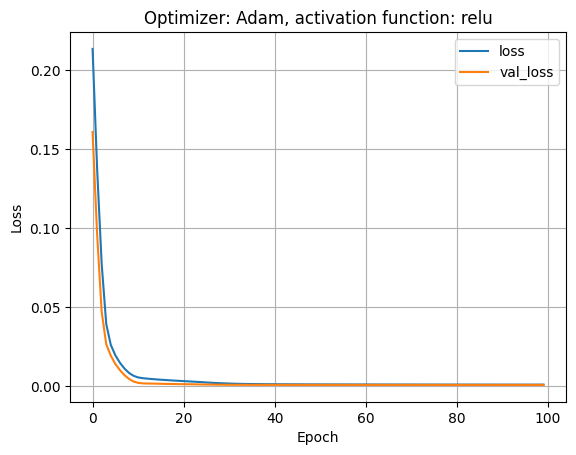

In [77]:
app_model = Sequential()
app_model.add(Dense(50, input_dim=3, activation='relu'))
app_model.add(Dense(50, activation='relu'))
app_model.add(Dense(5, activation='linear'))
app_model.compile(loss='mse', optimizer='Adam')

app_X_train, app_X_test, app_y_train, app_y_test = train_test_split(app_X, app_y, shuffle=True, random_state=0, train_size=0.8)
app_hist = app_model.fit(app_X_train, app_y_train, epochs=100, validation_split=0.01, batch_size=1000, verbose=0)
app_y_pred = app_model.predict(app_X_test)

app_y_test_inv = app_mms_y.inverse_transform(app_y_test)
app_y_pred_inv = app_mms_y.inverse_transform(app_y_pred)

print('R2={:.4f}  RMSE={:.2f}  MAE={:.2f}'.format(r2_score(app_y_test, app_y_pred),
    mean_squared_error(app_y_test_inv, app_y_pred_inv)**0.5,
    mean_absolute_error(app_y_test_inv, app_y_pred_inv)))

plot_loss(app_hist, 'Adam', 'relu')

In [78]:
app_model.summary()

Model: "sequential_641"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1923 (Dense)          (None, 50)                200       
                                                                 
 dense_1924 (Dense)          (None, 50)                2550      
                                                                 
 dense_1925 (Dense)          (None, 5)                 255       
                                                                 
Total params: 3,005
Trainable params: 3,005
Non-trainable params: 0
_________________________________________________________________


Saving MinMaxScaler for using in an outside python client:

In [79]:
with open('/kaggle/working/mmsx.pkl', 'wb') as f:
    pickle.dump(app_MMS_X, f)
    f.close()
    
with open('/kaggle/working/mmsy.pkl', 'wb') as f:
    pickle.dump(app_mms_y, f)
    f.close()        

Checking the saved objects:

In [80]:
with open('/kaggle/working/mmsx.pkl', 'rb') as f:
    loaded_MMS_x = pickle.load(f)
    f.close()
    
print( loaded_MMS_x.transform([[10,10,10]]) - app_MMS_X.transform([[10,10,10]]) )

with open('/kaggle/working/mmsy.pkl', 'rb') as f:
    loaded_mms_y = pickle.load(f)
    f.close()

print( loaded_mms_y.transform([[10,10,10,10,10]]) - app_mms_y.transform([[10,10,10,10,10]]) )

[[0. 0. 0.]]
[[0. 0. 0. 0. 0.]]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Saving MinMaxScaler for using in a С++ client:

In [81]:
with open('/kaggle/working/min_max_for_c++.txt', 'wt') as f:
    
    f.write('X=' + str(list(app_MMS_X.get_feature_names_out())) + '\n')
    f.write('app_MMS_X.data_min_=' + str(list(app_MMS_X.data_min_)) + '\n')
    f.write('app_MMS_X.data_max_=' + str(list(app_MMS_X.data_max_)) + '\n')
    
    f.write('y=' + str(list(app_mms_y.get_feature_names_out())) + '\n')
    f.write('app_mms_y.data_min_=' + str(list(app_mms_y.data_min_)) + '\n')
    f.write('app_mms_y.data_max_=' + str(list(app_mms_y.data_max_)) + '\n')
    
    f.close()

Saving the model for using in TensorFlow Serving:

In [82]:
save_model(
    app_model, '/kaggle/working/saved_model', overwrite=True, include_optimizer=True, 
    save_format=None, signatures= None, options=None)

In [83]:
!saved_model_cli show --dir {'/kaggle/working/saved_model'} --all

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_1923_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: serving_default_dense_1923_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1925'] tensor_info:
 

Saving the test set:

In [84]:
df.loc[app_X_test.index, app_X_cols].to_csv('/kaggle/working/Battery_RUL_X_test.csv')
df.loc[app_X_test.index, app_y_cols].to_csv('/kaggle/working/Battery_RUL_y_test.csv')

Quick visual check of the model:

In [85]:
pred_index = 11339 #  <--- indices can be borrowed from the test set app_X_test.index (see next cell)

X_norm = app_MMS_X.transform( [df.loc[pred_index][app_X_cols]] )
print('{} {} {} <--- Normalized X'.format(*X_norm[0]))

pred_norm = app_model.predict(X_norm)
print('{} {} {} {} {} <--- Normalized prediction \n'.format(*pred_norm.tolist()[0]))

pred_denorm = app_mms_y.inverse_transform(pred_norm)
print('{:.2f} {:.3f} {:.2f} {:.2f} {:.2f} <--- Denormalized prediction '.format(*pred_denorm.tolist()[0]))

true_y = [list(df.loc[pred_index][app_y_cols])]
print('{:.2f} {:.3f} {:.2f} {:.2f} {:.2f} <--- True y '.format(*true_y[0]))


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


0.16293843322040313 0.3682207421503332 0.4189166817693884 <--- Normalized X
1/1 [==============================] - 0s 152ms/step
0.2174702137708664 0.41445109248161316 0.5210568308830261 0.26461362838745117 0.4654386043548584 <--- Normalized prediction 

425.29 3.901 2836.61 3679.00 527.88 <--- Denormalized prediction 
394.29 3.864 2701.18 3572.38 533.00 <--- True y 


In [86]:
app_X_test.index[0:100]

Int64Index([11339, 14156,  7356,  1669,  7536, 12734,  7085, 13615,   843,
            10385,   578, 13670,  3759,  5068,  4874, 12467,  1427, 14457,
            10626, 14352,  3183, 10686, 14081,  1645, 10828,  2406, 11746,
             7918,  6560, 12345, 12062, 12322,  4832, 11292,  4046,  8571,
             8321,  8162,  9665, 12378,   845,  9242,  5864, 12715, 14512,
            11455,  1595, 14638,   920,  4447,  8016,  1471, 12640,  6866,
            12749,  1638,  8355,  2491,  2712,  4503, 11453,   575,  1187,
            14333,  6802, 10455,  2777,  3476,  3735,  4707, 11444, 13652,
             5398,  7958,  9787,  5090,  2643,  4003,  5034, 13563, 10487,
            13016, 10150,  7545, 10793, 13627,  6906,  2883,  3930,  9131,
            11320,  2400,  9754,  3283,  4304,  2799, 14283,  9552,  4855,
             1894],
           dtype='int64')

The C++ client app is stored here:

https://github.com/petr-larin/BMSTU-Graduate-Qualifying-Project/tree/main/tensorflow-serving-client-win

and its screenshot is here:

https://github.com/petr-larin/BMSTU-Graduate-Qualifying-Project